In [18]:
import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt

In [26]:
csv_path = "../pose_data_movement_50Hz1763592656.75.csv"
df  = pd.read_csv(csv_path)
if "t" not in df.columns and "time" in df.columns:
    df = df.rename(columns={"time":"t"})

<Axes: xlabel='x', ylabel='y'>

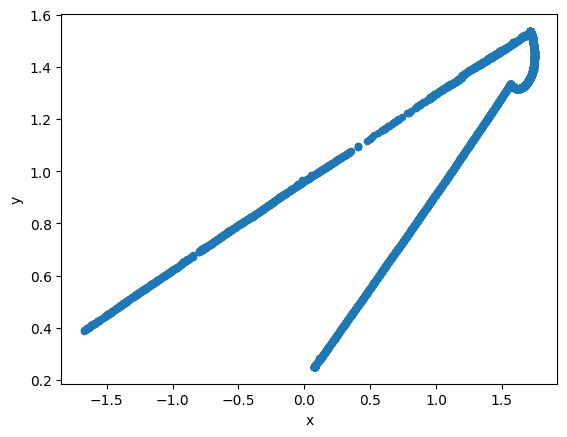

In [27]:
df.plot(x = "x", y="y", kind="scatter")

<Axes: xlabel='t'>

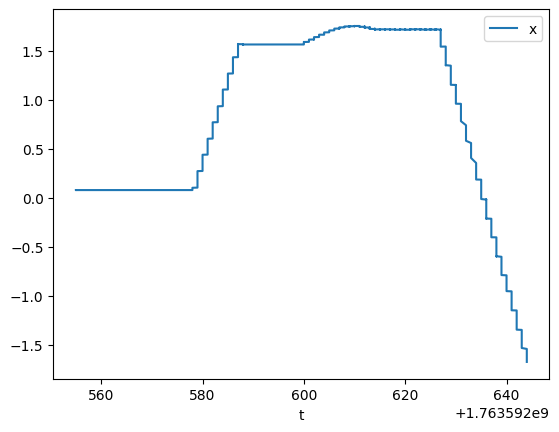

In [29]:
df.plot(x = "t", y="x", kind="line")

Text(0, 0.5, 'dx/dt')

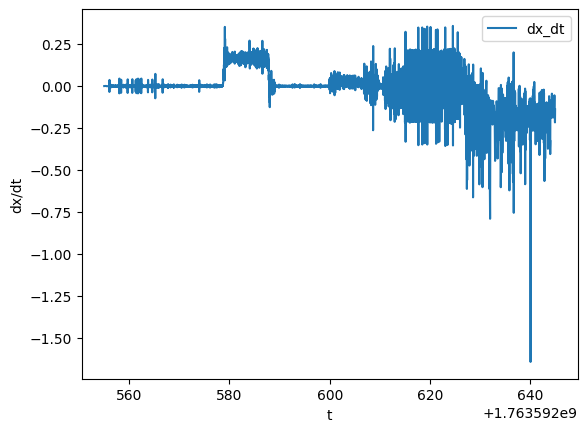

In [34]:
import numpy as np

# make sure time is sorted
df = df.sort_values('t')

# derivative w.r.t. time
df['dx_dt'] = np.gradient(df['x'].to_numpy(), df['t'].to_numpy())

ax = df.plot(x='t', y='dx_dt', kind='line')
ax.set_ylabel('dx/dt')


<Axes: xlabel='t'>

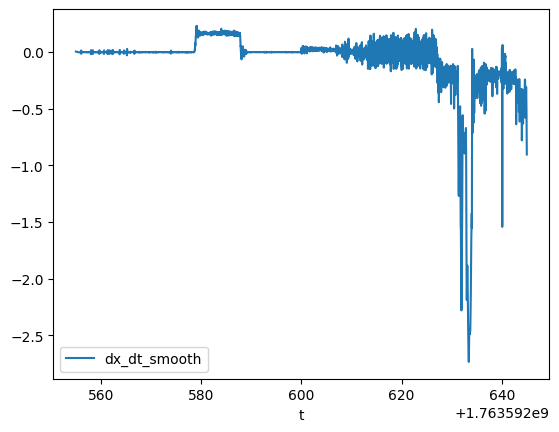

In [33]:
import numpy as np
from scipy.signal import savgol_filter

df = df.sort_values('t')
dt_med = np.median(np.diff(df['t']))

df['dx_dt_smooth'] = savgol_filter(
    df['x'].to_numpy(), window_length=11, polyorder=3, deriv=1, delta=dt_med
)
df.plot(x='t', y='dx_dt_smooth', kind='line')


In [30]:
# Reconstruct sub-second timing if 't' looks like integers / duplicates
def build_time_axis(series):
    t = series.to_numpy()
    if np.issubdtype(series.dtype, np.floating) and len(np.unique(np.round(t,6))) > 0.9*len(t):
        return t
    s = pd.Series(t)
    counts = s.map(s.value_counts())
    ranks  = s.groupby(s).cumcount()
    return (s + ranks / counts).to_numpy()

df["t"] = build_time_axis(df["t"])
df = df.sort_values("t").reset_index(drop=True)

dt = np.diff(df["t"], prepend=df["t"].iloc[0])
dt[0] = np.median(dt[1:])
df["dt"] = dt
fs = 1.0 / np.median(dt[1:])
print(f"Estimated sampling: {fs:.2f} Hz (median dt={np.median(dt[1:]):.4f} s)")

Estimated sampling: 120.00 Hz (median dt=0.0083 s)


# EKF

In [31]:
def angwrap(a):
    """Wrap angle to [-pi, pi)."""
    return (a + np.pi) % (2*np.pi) - np.pi

def ekf_unicycle(df, meas_cols=("x","y","gamma"),
                 R_diag=(0.02**2, 0.02**2, (1*np.pi/180)**2),
                 q_v=0.3**2, q_w=(3*np.pi/180)**2,
                 gate_N=5.0):
    """
    R_diag: measurement noise variances (x [m], y [m], theta [rad])
    q_v, q_w: process noise variances (random walks for v [m/s] and omega [rad/s])
    gate_N: Mahalanobis gating threshold (sqrt of chi^2 dof=3 ~ 3.0 is moderate)
    """
    x_m, y_m, th_m = (df[c].to_numpy() for c in meas_cols)
    t = df["t"].to_numpy()
    dt = df["dt"].to_numpy()

    N = len(df)
    # State: [x, y, theta, v, omega]
    X = np.zeros((N,5))
    P = np.zeros((N,5,5))

    # Initialize from first two samples
    X[0,0] = x_m[0]
    X[0,1] = y_m[0]
    X[0,2] = th_m[0]
    # crude finite-diff for initial v, omega
    if N > 3:
        dth = angwrap(th_m[2] - th_m[0]) / max(t[2]-t[0], 1e-3)
        dx  = (x_m[2] - x_m[0]) / max(t[2]-t[0], 1e-3)
        dy  = (y_m[2] - y_m[0]) / max(t[2]-t[0], 1e-3)
        v0  = np.hypot(dx, dy)
        w0  = dth
    else:
        v0, w0 = 0.0, 0.0
    X[0,3] = v0
    X[0,4] = w0

    # Initial covariance
    P0 = np.diag([0.05**2, 0.05**2, (5*np.pi/180)**2, 0.5**2, (20*np.pi/180)**2])
    P[0] = P0

    R = np.diag(R_diag)

    for k in range(1, N):
        dtk = max(dt[k], 1e-6)

        # ----- Predict -----
        x, y, th, v, w = X[k-1]

        # Nonlinear motion
        x_pred  = x + v * np.cos(th) * dtk
        y_pred  = y + v * np.sin(th) * dtk
        th_pred = angwrap(th + w * dtk)
        v_pred  = v
        w_pred  = w
        xk_pred = np.array([x_pred, y_pred, th_pred, v_pred, w_pred])

        # Jacobian F = df/dx
        F = np.eye(5)
        F[0,2] = -v * np.sin(th) * dtk   # d(x)/d(theta)
        F[0,3] =  np.cos(th) * dtk       # d(x)/d(v)
        F[1,2] =  v * np.cos(th) * dtk   # d(y)/d(theta)
        F[1,3] =  np.sin(th) * dtk       # d(y)/d(v)
        F[2,4] =  dtk                    # d(theta)/d(omega)

        # Process noise (random walks on v and omega)
        Q = np.zeros((5,5))
        Q[3,3] = q_v * dtk   # scale by dt (discrete-time approx)
        Q[4,4] = q_w * dtk

        P_pred = F @ P[k-1] @ F.T + Q

        # ----- Update (measurement z = [x, y, theta]) -----
        z = np.array([x_m[k], y_m[k], th_m[k]])

        # h(x)
        hx = np.array([xk_pred[0], xk_pred[1], xk_pred[2]])
        # Innovation with angle wrap on theta
        y_tilde = z - hx
        y_tilde[2] = angwrap(y_tilde[2])

        H = np.zeros((3,5))
        H[0,0] = 1.0
        H[1,1] = 1.0
        H[2,2] = 1.0

        S = H @ P_pred @ H.T + R
        # Mahalanobis gating
        maha = float(y_tilde.T @ inv(S) @ y_tilde)
        if maha < gate_N**2:
            K = P_pred @ H.T @ inv(S)
            xk_upd = xk_pred + K @ y_tilde
            xk_upd[2] = angwrap(xk_upd[2])
            P_upd = (np.eye(5) - K @ H) @ P_pred
        else:
            # skip update if outlier
            xk_upd, P_upd = xk_pred, P_pred

        X[k] = xk_upd
        P[k] = P_upd

    # Build results DataFrame
    res = pd.DataFrame({
        "t": df["t"],
        "x_hat": X[:,0],
        "y_hat": X[:,1],
        "theta_hat": X[:,2],
        "v_hat": X[:,3],
        "omega_hat": X[:,4],
    })
    # world-frame velocity components from state
    res["vx_world"] = res["v_hat"] * np.cos(res["theta_hat"])
    res["vy_world"] = res["v_hat"] * np.sin(res["theta_hat"])
    res["speed"]    = res["v_hat"].abs()
    return res, P

# Run EKF
ekf_df, cov_seq = ekf_unicycle(df)
ekf_df.head()


,t,x_hat,y_hat,theta_hat,v_hat,omega_hat,vx_world,vy_world,speed
0,1.763593e+09,0.078118,0.251429,-0.185688,0.000151,-0.001127,0.000149,-0.000028,0.000151
1,1.763593e+09,0.078110,0.251424,-0.185744,0.000046,-0.001067,0.000045,-0.000009,0.000046
2,1.763593e+09,0.078115,0.251439,-0.185883,0.000035,-0.001410,0.000034,-0.000006,0.000035
3,1.763593e+09,0.078098,0.251435,-0.185769,-0.000084,0.000056,-0.000083,0.000016,0.000084
4,1.763593e+09,0.078201,0.251455,-0.186088,0.000449,-0.001423,0.000441,-0.000083,0.000449


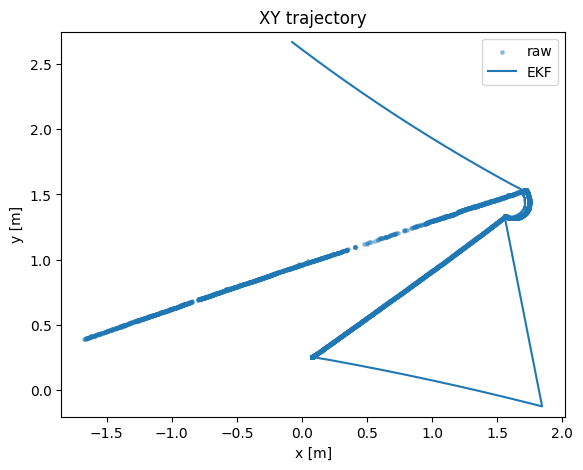

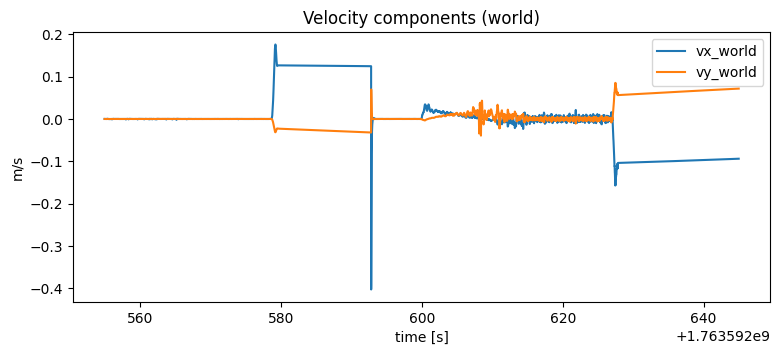

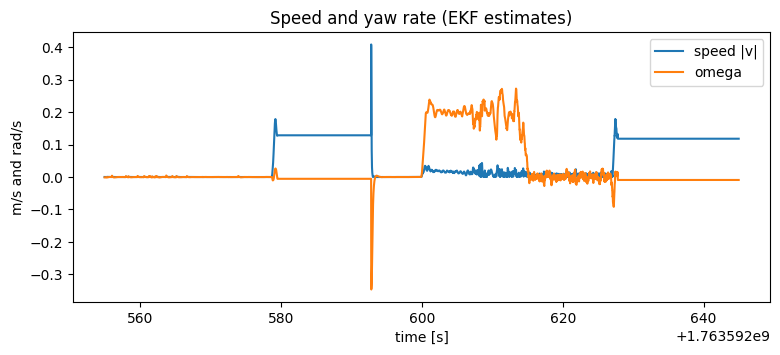

In [32]:
# Ensure pyplot is correct
try: del plt
except NameError: pass
import matplotlib.pyplot as plt

# XY trajectory (raw vs EKF)
plt.figure(figsize=(6.5,5))
plt.scatter(df["x"], df["y"], s=6, alpha=0.4, label="raw")
plt.plot(ekf_df["x_hat"], ekf_df["y_hat"], linewidth=1.5, label="EKF")
plt.gca().set_aspect("equal", adjustable="datalim")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title("XY trajectory")
plt.legend()
plt.show()

# Velocity components in world frame
plt.figure(figsize=(9,3.5))
plt.plot(ekf_df["t"], ekf_df["vx_world"], label="vx_world")
plt.plot(ekf_df["t"], ekf_df["vy_world"], label="vy_world")
plt.xlabel("time [s]"); plt.ylabel("m/s")
plt.title("Velocity components (world)")
plt.legend()
plt.show()

# Speed and yaw rate
plt.figure(figsize=(9,3.5))
plt.plot(ekf_df["t"], ekf_df["speed"], label="speed |v|")
plt.plot(ekf_df["t"], ekf_df["omega_hat"], label="omega")
plt.xlabel("time [s]"); plt.ylabel("m/s and rad/s")
plt.title("Speed and yaw rate (EKF estimates)")
plt.legend()
plt.show()


In [ ]:
Vx = V*math.cos(theta)
Vy = V*math.sin(theta)